C:\Users\iamsa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\iamsa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\iamsa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\iamsa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

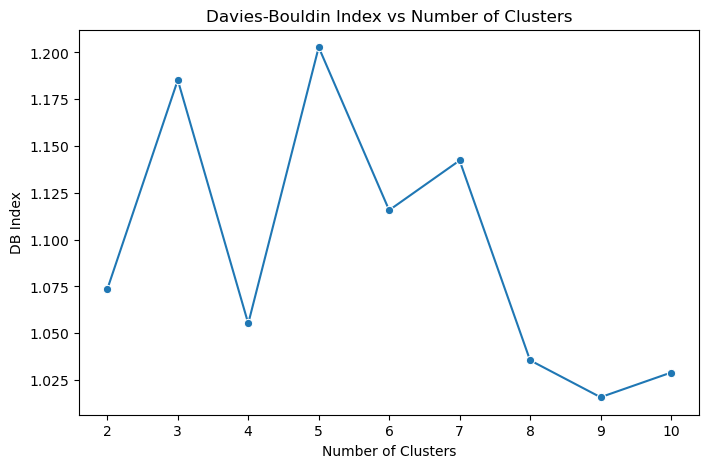

Optimal number of clusters based on DB Index: 9


C:\Users\iamsa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


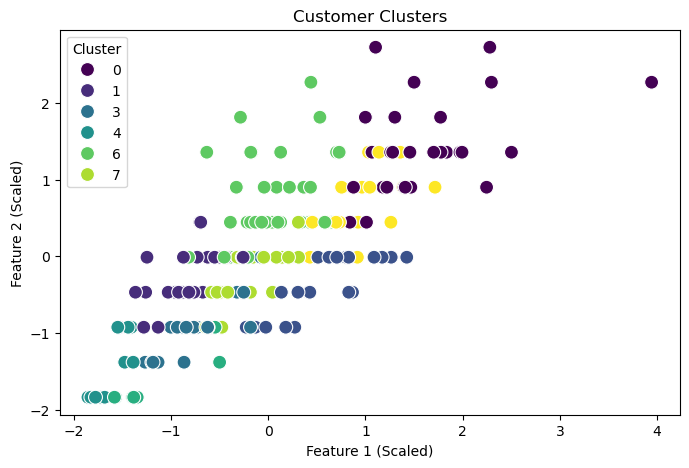

Davies-Bouldin Index for final clustering: 1.0158571508225327
Cluster assignments saved to 'Customer_Clusters.csv'


In [7]:
#Task 3: Customer Segmentation / Clustering

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers_url = 'https://drive.google.com/uc?id=1bu_--mo79VdUG9oin4ybfFGRUSXAe-WE'
products_url = 'https://drive.google.com/uc?id=1IKuDizVapw-hyktwfpoAoaGtHtTNHfd0'
transactions_url = 'https://drive.google.com/uc?id=1saEqdbBB-vuk2hxoAf4TzDEsykdKlzbF'

customers = pd.read_csv(customers_url)
products = pd.read_csv(products_url)
transactions = pd.read_csv(transactions_url)

# Merge datasets
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
merged_data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

# Feature Engineering
customer_features = merged_data.groupby('CustomerID').agg(
    total_spending=('TotalValue', 'sum'),
    num_transactions=('TransactionID', 'count'),
    avg_transaction_value=('TotalValue', 'mean'),
    num_categories=('Category', 'nunique')
).reset_index()

# Normalize features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(customer_features.iloc[:, 1:])

# Determine optimal number of clusters using DB Index
db_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(normalized_features)
    db_index = davies_bouldin_score(normalized_features, cluster_labels)
    db_scores.append((k, db_index))

# Plot DB Index vs. Number of Clusters
db_df = pd.DataFrame(db_scores, columns=['Clusters', 'DB_Index'])
plt.figure(figsize=(8, 5))
sns.lineplot(x='Clusters', y='DB_Index', data=db_df, marker='o')
plt.title("Davies-Bouldin Index vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("DB Index")
plt.show()

# Choose the optimal number of clusters (minimum DB Index)
optimal_clusters = db_df.loc[db_df['DB_Index'].idxmin(), 'Clusters']
print(f"Optimal number of clusters based on DB Index: {optimal_clusters}")

# Perform Clustering with Optimal Clusters
kmeans = KMeans(n_clusters=int(optimal_clusters), random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(normalized_features)

# Visualize Clusters
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x=normalized_features[:, 0],
    y=normalized_features[:, 1],
    hue=customer_features['Cluster'],
    palette='viridis',
    s=100
)
plt.title("Customer Clusters")
plt.xlabel("Feature 1 (Scaled)")
plt.ylabel("Feature 2 (Scaled)")
plt.legend(title="Cluster")
plt.show()

# Clustering Metrics
final_db_index = davies_bouldin_score(normalized_features, customer_features['Cluster'])
print(f"Davies-Bouldin Index for final clustering: {final_db_index}")

# Save Cluster Assignments
customer_features[['CustomerID', 'Cluster']].to_csv('Customer_Clusters.csv', index=False)
print("Cluster assignments saved to 'Customer_Clusters.csv'")
